In [1]:
import tensorflow as tf

2024-07-01 00:06:53.892384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 00:06:53.892446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 00:06:53.893845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Mixed Precision Training
Mixed precision training is the use of lower-precision operations (float16 and bfloat16) in a model during training to make it run faster and use less memory. Using mixed precision can improve performance by more than 3 times on modern GPUs and 60% on TPUs.
Most models use the float32 dtype, which takes 32 bits of memory. However, there are two lower-precision dtypes, float16 and bfloat16, each which take 16 bits of memory instead which is suitable for modern accelerators as they can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

In [ ]:
# tf.keras.mixed_precision.set_global_policy("mixed_bfloat16") # For TPU
# tf.keras.mixed_precision.set_global_policy('mixed_float16') # For GPU 

# Import Dependencies

In [2]:
# Import standard dependencies
import random
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
import gc

# Import tensorflow dependencies - Functional API


# image preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

# to build model
from keras.models import Model
from tensorflow.keras.layers import Rescaling, Input, Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.activations import softmax

# cost function / optimizer
from tensorflow.keras.optimizers import SGD, Adamax
from sklearn.metrics import confusion_matrix

from tensorflow.keras.backend import clear_session

In [3]:
SEED = 6302024
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Building Pathes and Labels Lists

In [4]:
MAIN_DIR="/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos"
Categories= ["Benign","InSitu","Invasive","Normal"]
encoding = { 'Normal': 0, 'Benign': 1, 'InSitu': 2, 'Invasive': 3 }

# create an empty list which will contain the subdirectory names of the `dataset` directory with more than one image in it
imagesPathes = []
labels = []
# iterate over the subdirectories in the dataset directory
for category in Categories:
    for image in os.listdir(os.path.join(MAIN_DIR, category)):
        if os.path.splitext(image)[1]==".tif":
            imagePath = os.path.join(MAIN_DIR,category, image)
            labels.append(encoding[category])
            imagesPathes.append(imagePath)
examples_count=len(imagesPathes)
print(len(imagesPathes))
print(len(labels))

400
400


In [5]:
indices = np.random.permutation(np.arange(examples_count)) # np.arange(examples_count) gives indices
print(indices[:10])
imagesPathes = np.array(imagesPathes)[indices]
labels = np.array(labels)[indices]

[249   4 259 324 357 245 261 122 172 196]


# Building Data Pipeline

## Loading Data Into The Pipeline

In [6]:
ds = tf.data.Dataset.from_tensor_slices((imagesPathes,labels))

# One Hot Encoding

In [7]:
def Hot_Encoding(features, labels):
    # Convert labels to one-hot
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    return features, labels
ds=ds.map(Hot_Encoding)

## Preprocessing The Data

In [8]:
imgShape = (384, 512, 3)

In [9]:
def preprocess(img_path, label):
    # Define a nested function to handle image loading and preprocessing
    def load_and_preprocess_image(img_path):
        # Convert the img_path from tensor to string
        img_path = img_path.numpy().decode('UTF-8')
        # Read the image file using OpenCV
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # Convert from BGR to RGB (OpenCV default is BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image
        img = cv2.resize(img, (imgShape[1], imgShape[0]))
#         # Normalize the image to the range [-1, 1]
#         img = img / 127.5 - 1.0
        return img.astype(np.float32)

    # Use tf.py_function to wrap the Python function
    img = tf.py_function(load_and_preprocess_image, [img_path], tf.float32)
    # Set the shape of the image after modification by the tf.py_function
    img.set_shape(imgShape)

    return img, label

## Build Train and Validation Partition

In [10]:
train_size = int(examples_count * 0.60)
test_val_size = examples_count-train_size

val_size = int(test_val_size * 0.5)
test_size = test_val_size - val_size


# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

240
80
80


## Visualizing Some Examples

/tmp/ipykernel_4088/1540584984.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, idx + 1)


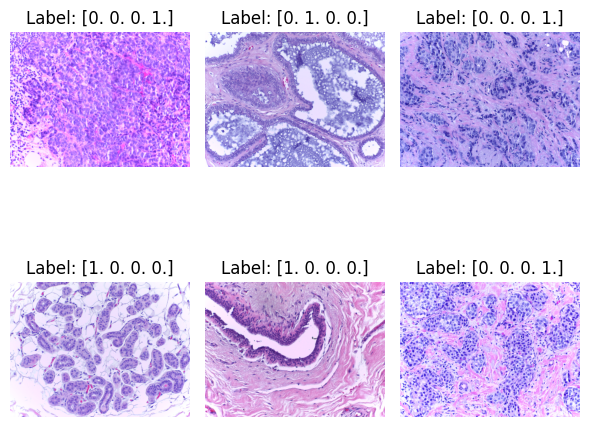

In [11]:
# Plotting first 6 examples

plt.figure(figsize=(6, 6))
plt.axis('off')
for idx, (image, label) in enumerate(train_ds.take(6)):

    ax = plt.subplot(2, 3, idx + 1)

    # Plot the image
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

/tmp/ipykernel_4088/171007510.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, idx + 1)


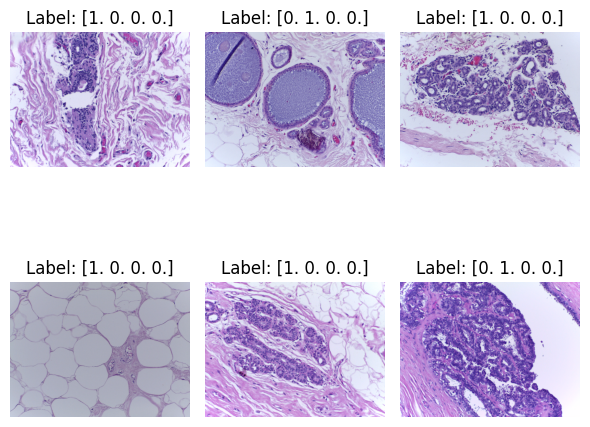

In [12]:
# Plotting first 6 examples

plt.figure(figsize=(6, 6))
plt.axis('off')
for idx, (image, label) in enumerate(val_ds.take(6)):

    ax = plt.subplot(2, 3, idx + 1)
    
    # Plot the image
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

/tmp/ipykernel_4088/2645223239.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, idx + 1)


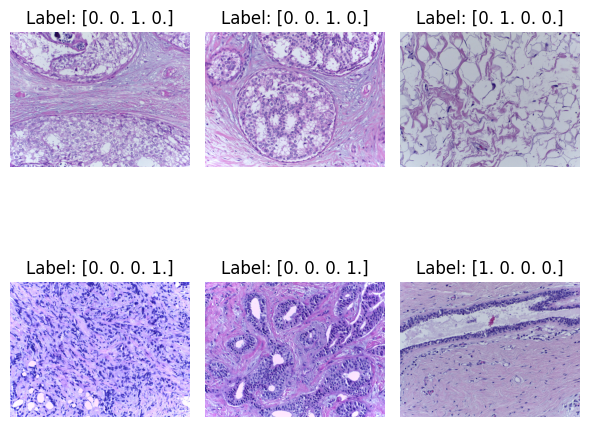

In [13]:
# Plotting first 6 examples

plt.figure(figsize=(6, 6))
plt.axis('off')
for idx, (image, label) in enumerate(test_ds.take(6)):

    ax = plt.subplot(2, 3, idx + 1)
    
    # Plot the image
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Data Augmantation

In [14]:
def random_horizontal_flip(img, label):
    img = tf.image.random_flip_left_right(img)
    return img, label
def random_vertical_flip(img, label):
    img = tf.image.random_flip_up_down(img)
    return img, label
def random_rotation(img, label):
    img = tf.image.rot90(img, k=1) #k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    return img, label
def random_hue(img, label):
    img = tf.image.random_hue(img, 0.1)
    return img, label

## Configure Dataset For Performance

In [15]:
"""
To train a model with this dataset you will want the data:
  To be well shuffled.
  To be batched.
  Batches to be available as soon as possible.
"""
batch_size = 16
def configure_for_performance(ds, shuffle=False, augment=False):
    if augment:
        ds=ds.map(random_horizontal_flip)\
             .map(random_vertical_flip)\
             .map(random_rotation)\
             .map(random_hue)
            
    if shuffle:
        ds=ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
train_ds = configure_for_performance(train_ds,augment=True)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

# CallBacks

In [17]:
class TestMonitor(tf.keras.callbacks.Callback):
    def __init__(self, test_data, verbose=0):
        super(TestMonitor, self).__init__()
        self.test_data = test_data
        self.verbose = verbose
        self.best_acc = None
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)

        if self.best_acc is None or acc >= self.best_acc:
            self.best_acc = acc
            self.best_weights = self.model.get_weights()

            if self.verbose > 0:
                print(f" Test Accuracy Improved ({self.best_acc:.4f}) - Saving Weights")
        else:
            if self.verbose > 0:
                print(f" Test Accuracy ({acc:.4f}) did not improve.")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print("Loaded weights with best Test Accuracy")

# Get Test Labels

In [18]:
true_labels = []
for img_batch, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())
true_labels = [np.argmax(label) for label in true_labels]
np.save('true_labels.npy', true_labels)

# Confusion Matrix

In [19]:
def plot_confusion_matrix(true_labels,predictions,modelname):
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True)
    plt.title(f"Confusion Matrix for {modelname}")
    plt.show()

# Input And Rescaling Layers

In [20]:
inputs = Input(shape=imgShape)
rescaling = Rescaling(1./127.5, offset=-1)(inputs)  # Rescale to [-1,1]
top_dropout_rate = .4

# Building And Training First Model

In [23]:
efficientV2M = tf.keras.applications.EfficientNetV2M(include_top=False, weights="imagenet", input_shape=imgShape)
efficientV2M.trainable = True
x = efficientV2M(inputs)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(top_dropout_rate, name="top_dropout")(x)
x = Dense(units=512, activation='relu', name="pred")(x)
output1 = Dense(4, activation='softmax')(x)
efficientV2M_model = Model(inputs, output1, name="efficientV2M")

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
efficientV2M_model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=['accuracy'])
print("Ready to train. Training is starting!\n")
callbacks = [TestMonitor(test_ds, verbose=1)]
hist1 = efficientV2M_model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=100,verbose=1)

Ready to train. Training is starting!

Epoch 1/100


I0000 00:00:1719788947.882743     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719788948.206606     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4674 - loss: 1.1913

W0000 00:00:1719788990.398902     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 Test Accuracy Improved (0.5875) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.4749 - loss: 1.1804 - val_accuracy: 0.6625 - val_loss: 1.2166
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8250 - loss: 0.4601 Test Accuracy Improved (0.7500) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 747ms/step - accuracy: 0.8266 - loss: 0.4557 - val_accuracy: 0.7125 - val_loss: 1.5529
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9646 - loss: 0.1100 Test Accuracy Improved (0.7625) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 735ms/step - accuracy: 0.9637 - loss: 0.1118 - val_accuracy: 0.7000 - val_loss: 1.1963
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9840 - loss: 0.0675 Test Accuracy Improved (0.8125) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 736ms/step - accuracy: 0.9832 - loss: 0.0688 - val_accuracy: 0.6750 - val_loss: 1.0401
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9785 

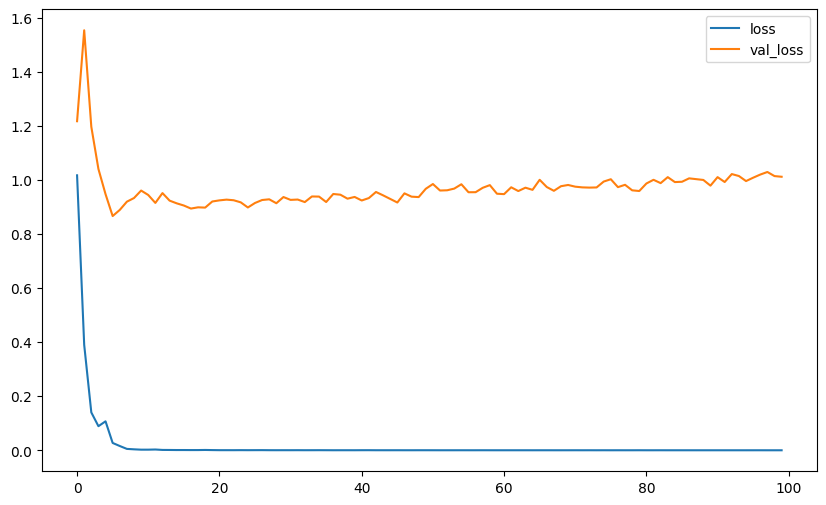

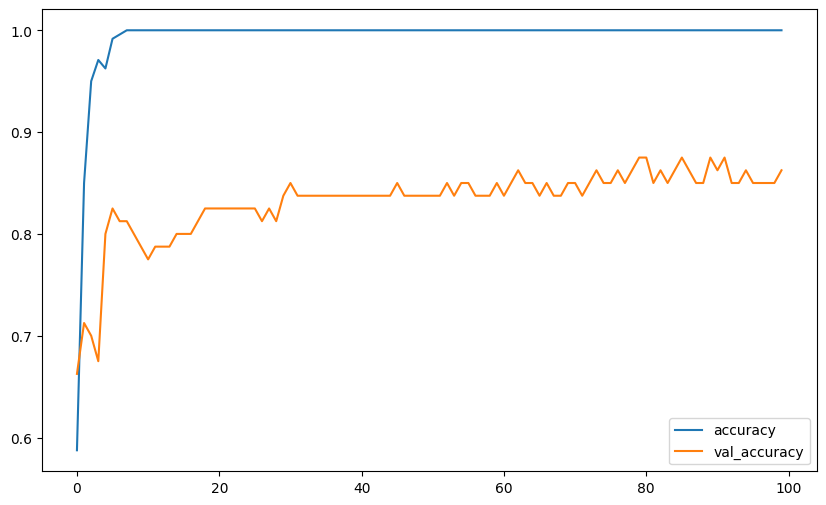

In [25]:
eps = range(len(hist1.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist1.history["loss"])
plt.plot(eps, hist1.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist1.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist1.history["accuracy"])
plt.plot(eps, hist1.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8556 - loss: 0.8467
Test accuracy: 90.00%
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

W0000 00:00:1719790903.387736     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step


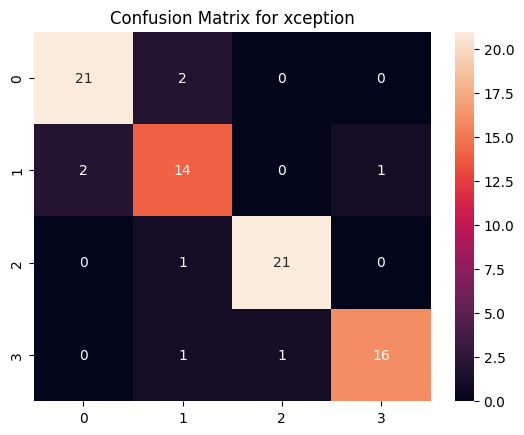

In [26]:
loss, accuracy = efficientV2M_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy*100:.2f}%")
predicted_labels_efficientV2M = np.argmax(efficientV2M_model.predict(test_ds), axis=1) 
plot_confusion_matrix(true_labels, predicted_labels_efficientV2M,"xception")
efficientV2M_model.save("efficientV2M.keras", include_optimizer = False)
np.save('evaluation_model_1.npy', predicted_labels_efficientV2M)

In [27]:
clear_session()
del efficientV2M_model
gc.collect()

0

# Building And Training Second Model

In [21]:
convNext = tf.keras.applications.ConvNeXtTiny(include_top=False, weights="imagenet", input_shape=imgShape)
convNext.trainable = True
x = convNext(inputs)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(top_dropout_rate, name="top_dropout")(x)
x = Dense(units=512, activation='relu', name="pred")(x)
output2 = Dense(4, activation='softmax')(x)
convNext_model = Model(inputs, output2, name="inception")

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
convNext_model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=['accuracy'])
print("Ready to train. Training is starting!\n")
callbacks = [TestMonitor(test_ds, verbose=1)]
hist2 = convNext_model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=100,verbose=1)

Ready to train. Training is starting!

Epoch 1/100


I0000 00:00:1719791096.766848    2104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719791096.823466    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.823801    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.824214    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.827352    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.827755    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.828238    2104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791096.828994    2104 graph_launch.cc:671] Fallback to op-by-op mode because m

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.2915 - loss: 1.6071

W0000 00:00:1719791112.067390    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791112.067758    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791112.068169    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791112.070934    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791112.071250    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719791112.071668    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 Test Accuracy Improved (0.4000) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.2941 - loss: 1.6041 - val_accuracy: 0.5000 - val_loss: 1.2358
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4828 - loss: 1.2969 Test Accuracy Improved (0.5500) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - accuracy: 0.4833 - loss: 1.2944 - val_accuracy: 0.5250 - val_loss: 1.0144
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5971 - loss: 0.9717 Test Accuracy Improved (0.7125) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 0.5988 - loss: 0.9686 - val_accuracy: 0.6375 - val_loss: 0.8742
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7125 - loss: 0.6520 Test Accuracy (0.6875) did not improve.
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 582ms/step - accuracy: 0.7156 - loss: 0.6479 - val_accuracy: 0.6625 - val_loss: 0.7930
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9134 - loss: 0.369

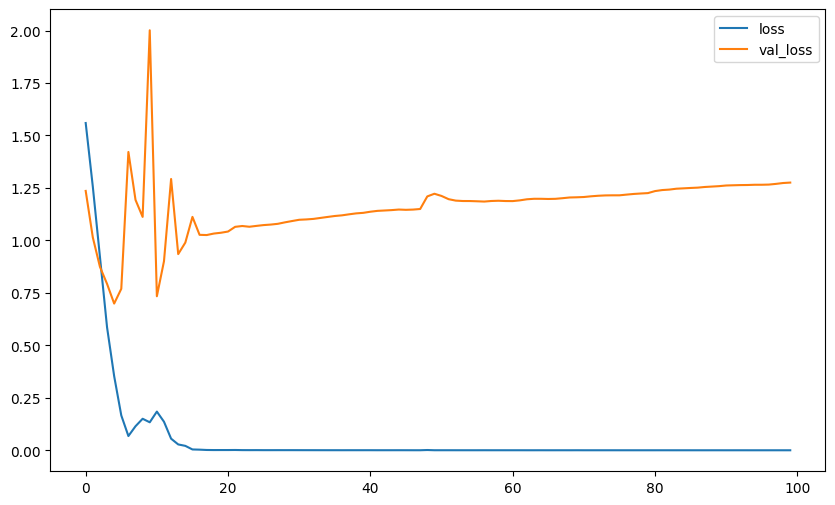

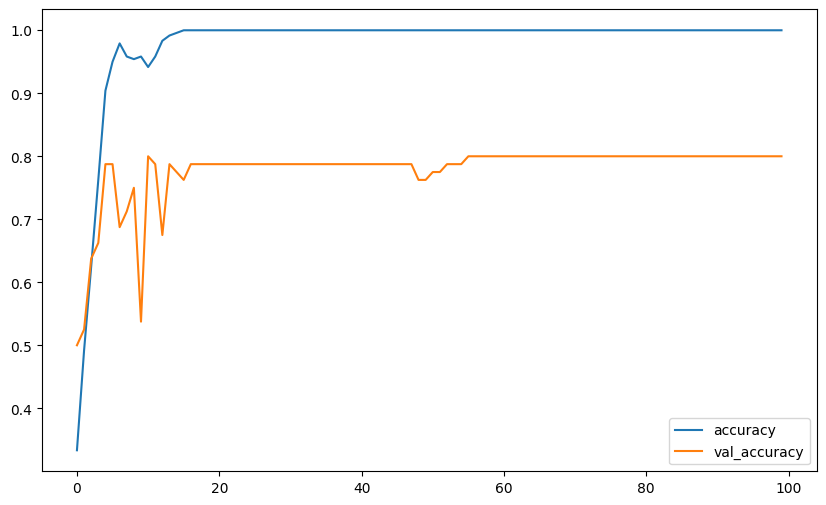

In [23]:
eps = range(len(hist2.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist2.history["loss"])
plt.plot(eps, hist2.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist2.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist2.history["accuracy"])
plt.plot(eps, hist2.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8457 - loss: 0.9665
Test accuracy: 86.25%
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

W0000 00:00:1719792308.475385    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719792308.475695    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719792308.476102    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719792308.478935    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719792308.479279    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719792308.479648    2105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step


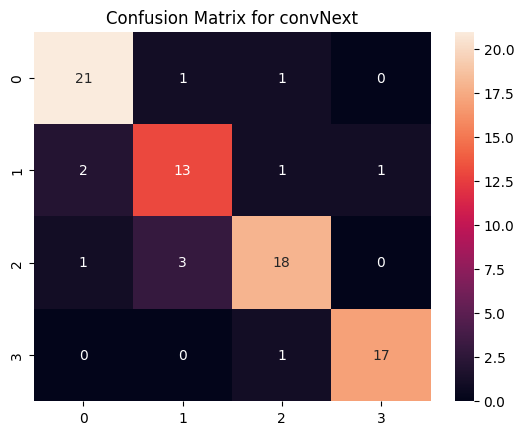

In [24]:
loss, accuracy = convNext_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy*100:.2f}%")
predicted_labels_convNext = np.argmax(convNext_model.predict(test_ds), axis=1) 
plot_confusion_matrix(true_labels, predicted_labels_convNext,"convNext")
convNext_model.save("convNext.keras", include_optimizer = False)
np.save('evaluation_model_2.npy', predicted_labels_convNext)

In [25]:
clear_session()
del convNext_model
gc.collect()

0

# Building And Training Third Model

In [21]:
efficientB3 = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=imgShape)
efficientB3.trainable = True
x = efficientB3(inputs)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(top_dropout_rate, name="top_dropout")(x)
x = Dense(units=512, activation='relu', name="pred")(x)
output3 = Dense(4, activation='softmax')(x)
efficientB3_model = Model(inputs, output3, name="efficientB3")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
efficientB3_model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=['accuracy'])
print("Ready to train. Training is starting!\n")
callbacks = [TestMonitor(test_ds, verbose=1)]
hist3 = efficientB3_model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=100,verbose=1)

Ready to train. Training is starting!

Epoch 1/100


I0000 00:00:1719792617.754120    4133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4763 - loss: 1.1967 Test Accuracy Improved (0.5375) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.4830 - loss: 1.1843 - val_accuracy: 0.5875 - val_loss: 0.9431
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9211 - loss: 0.2781 Test Accuracy Improved (0.6500) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - accuracy: 0.9216 - loss: 0.2748 - val_accuracy: 0.6625 - val_loss: 0.7660
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9988 - loss: 0.0460 Test Accuracy Improved (0.7125) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - accuracy: 0.9984 - loss: 0.0458 - val_accuracy: 0.7875 - val_loss: 0.6116
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 1.0000 - loss: 0.0132 Test Accuracy Improved (0.7750) - Saving Weights
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.8250 - val_loss: 0.5797
E

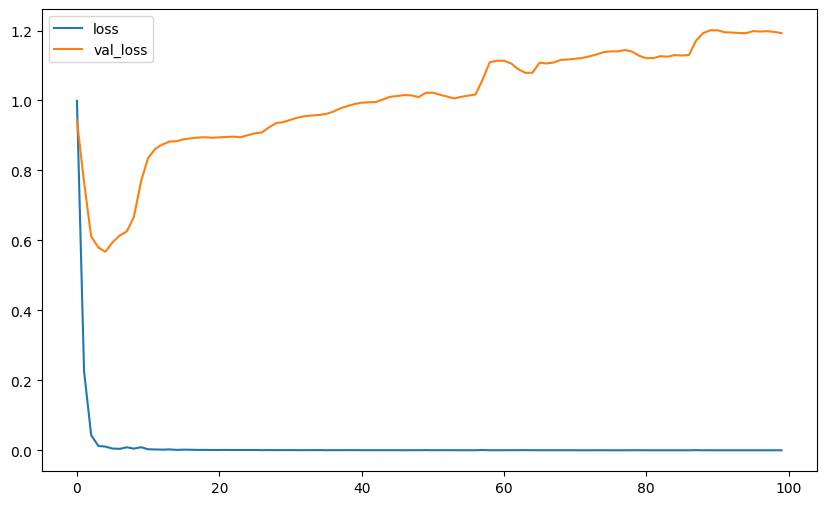

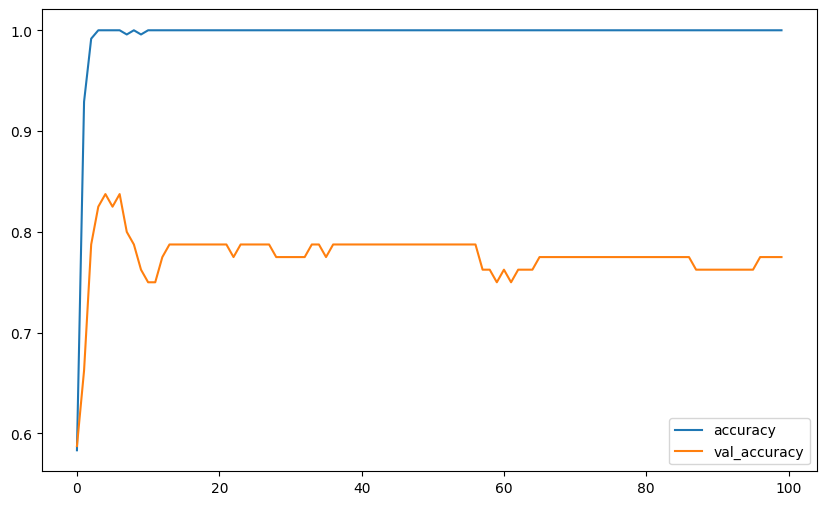

In [23]:
eps = range(len(hist3.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist3.history["loss"])
plt.plot(eps, hist3.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist3.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist3.history["accuracy"])
plt.plot(eps, hist3.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8781 - loss: 0.8232
Test accuracy: 90.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


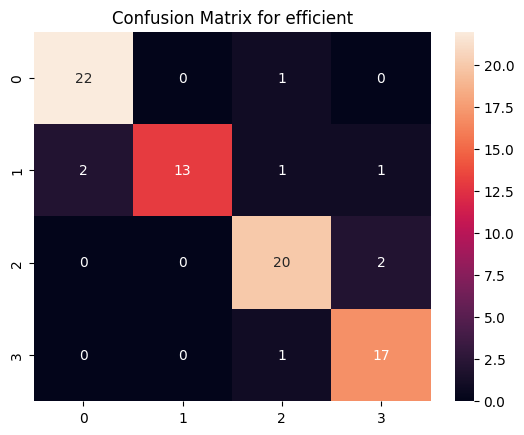

In [25]:
loss, accuracy = efficientB3_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy*100:.2f}%")
predicted_labels_efficientB3 = np.argmax(efficientB3_model.predict(test_ds), axis=1) 
plot_confusion_matrix(true_labels, predicted_labels_efficientB3,"efficient")
efficientB3_model.save("efficientB3.keras", include_optimizer = False)
np.save('evaluation_model_3.npy', predicted_labels_efficientB3)

In [26]:
clear_session()
del efficientB3_model
gc.collect()

0

In [27]:
true_labels = np.load('true_labels.npy')
predictions_list = []
predictions_list.append(np.load('evaluation_model_1.npy'))
predictions_list.append(np.load('evaluation_model_2.npy'))
predictions_list.append(np.load('evaluation_model_3.npy'))

In [30]:
# Ensemble predictions by majority vote
ensemble_predictions = np.array(predictions_list)
majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=4).argmax(), 0, ensemble_predictions)

Ensemble Confusion Matrix:
[[22  1  0  0]
 [ 2 13  1  1]
 [ 1  1 20  0]
 [ 0  0  1 17]]
Ensemble Accuracy: 0.90%


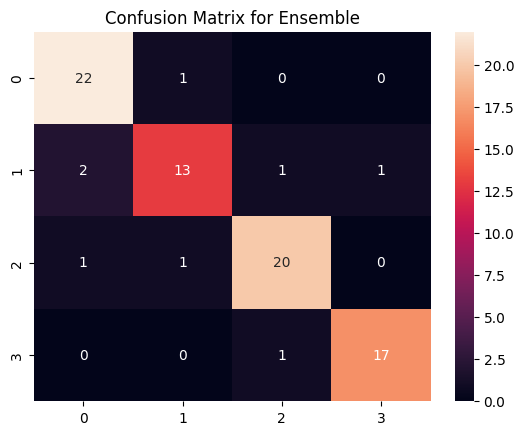

In [31]:
# Calculate confusion matrix and accuracy for the ensemble
ensemble_cm = confusion_matrix(true_labels, majority_vote)
ensemble_accuracy = accuracy_score(true_labels, majority_vote)
print("Ensemble Confusion Matrix:")
print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}%")
sns.heatmap(ensemble_cm, annot=True)
plt.title("Confusion Matrix for Ensemble")
plt.show()